# Langmuir isotherm predictions improved by modeling relative life with Gaussian process

---

## Introduction

The Langmuir isotherm model assumes constant relative life.[$^{[1]}$](#1) The Toth isotherm model modifies the Langmuir model to provide an empirical improvement. The Toth model was found to fit $q(T, p)$ measurements for zeolite 13X the best.[$^{[2]}$](#2) However, applying a Gaussian regression (GP) to the relative life of the Langmuir model fit even better than the Toth model. The advantage of this method is an improved fit despite the Langmuir isotherm model retaining its simpler analytic form as compared to empirical modifications, such as the Toth isotherm model.

---

## Method

The nomenclature was largely taken from [[1]](#1). In order of appearance in the following equations,

- $\mathbf{GP} \equiv$ Gaussian process model trained using FoKL-GPy
- $\Delta \equiv$ exponent of relative life
- $T \equiv$ temperature
- $p \equiv$ pressure
- $\sigma_1 \equiv$ relative life
- $q \equiv$ amount adsorbed
- $\mu \equiv$ number of gas molecules striking each surface area per time
- $q_{max} \equiv$ maximum possible value of amount adsorbed $q$
- $M \equiv$ molecular weight of adsorbent
- $R \equiv$ universal gas constant
- $q_{cal} \equiv$ calculated predictions of amount adsorbed $q$
- $\sigma_{1, cal} \equiv$ calculated predictions of relative life $\sigma_1$
- $q_s \equiv$ Toth isotherm model parameter theoretically equal to $q_{max}$
- $b \equiv$ Toth isotherm model parameter
- $t \equiv$ Toth isotherm model parameter

The GP model $\mathbf{GP}$ will be trained on $\Delta$ as a function of inverse temperature $T$ and natural logarithim of pressure $p$.

$$\tag{1} \mathbf{GP} = \{\Delta\ |\ T^{-1},\ \ln(p)\}$$

$$\tag{2} \Delta = \ln(\sigma_1)$$

$$\tag{3} \sigma_1 = \frac{q}{\mu(q_{max}-q)}$$

$$\tag{4} \mu = \frac{p}{\sqrt{2 \pi M R T}}$$

$$\tag{5} q_{max} = q_s$$

Then, to make predictions $q_{cal}$ from $\mathbf{GP}$,

$$\tag{6} q_{cal} = \frac{\sigma_{1, cal} q_{max} \mu}{1 + \sigma_{1, cal} \mu}$$

$$\tag{7} \sigma_{1, cal} = \exp(\mathbf{GP})$$

Note from Table 2 and Table 4 of [[2]](#2), respectively, experimental measurements $q(T, p)$ are saved as *data.txt* and Toth model parameters $(q_s, b, t)$ are saved as *toth.txt*. From Equation 2 of [[2]](#2), the Toth model is as follows.

$$\tag{8} q = \frac{q_s p}{(b+p^t)^{1/t}}$$

To obtain $q_{max}$ at any $(T, p)$ pair assuming $q_{max} \propto T$,

$$\tag{9} \mathbf{GP}_{q_{max}} = \{q_{max}\ |\ T\}$$

Since direct measurements of $q_{max}$ were not reported, $q_{max}=q_s$ was assumed for training $\mathbf{GP}_{q_{max}}$; however, experimental or literature values may produce a more accurate model in future work. 

---

## Implementation

Defining limits of where model may be evaluated, increased at the cost of accuracy:

In [1]:
T_min = 200  # Kelvin, temperature
T_max = 400

p_min = 0.01  # kPa, pressure
p_max = 150

Importing modules and defining constants:

In [2]:
# -----------------------------------------------------------------------
# Local version of 'from FoKL import ...':
import os
import sys
dir = os.path.abspath('')  # directory of script
sys.path.append(dir)
sys.path.append(os.path.join(dir, '..', '..', '..'))  # package directory
from src.FoKL import FoKLRoutines
from src.FoKL.fokl_to_pyomo import fokl_to_pyomo
# -----------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import pyomo.environ as pyo
from pyomo.environ import *


M = 0.0440095  # molecular weight of CO2, kg/mol
R = 8.31446261815324  # universal gas constant, J/(K*mol)

Loading and parsing data:

In [3]:
# Experimental measurements:

data = np.loadtxt(os.path.join('data', 'data.txt'), skiprows=2)  # experimental measurements q(T, p)

T = data[:, 0]  # K
p_kPa = data[:, 1]  # kPa
p = p_kPa * 1e3  # kPa to Pa
q = data[:, 2]  # mol/kg

T_const = np.where(T[:-1] != T[1:])[0]  # indices where experiment ends (i.e., where next temperature changes)
T_const = np.insert(T_const + 1, [0, len(T_const)], [0, len(T)])  # indices where experiments begin (including "next" experiment enabling 'data[T_const[i]:T_const[i + 1], :]')
n = len(T_const) - 1  # number of experiments
nd = np.array(list(T_const[i + 1] - T_const[i] for i in range(n)))  # number of datapoints in each experiment

# Toth model:

toth = np.loadtxt(os.path.join('data', 'toth.txt'), skiprows=2)  # model parameters (qs, b, t)

qs = np.repeat(toth[:, 1], nd)  # mol/kg, 'np.repeat(x, nd)' for repeating experiments' single values at each datapoint
b = np.repeat(toth[:, 2], nd)  # kPa
t = np.repeat(toth[:, 3], nd)

Defining equations:

In [4]:
def eq2(sigma1):
    """Delta"""
    return np.log(sigma1)

def eq3(q, mu, qmax):
    """sigma1"""
    return q / mu / (qmax - q)

def eq4(p, M, R, T):
    """mu"""
    return p / np.sqrt(2 * np.pi * M * R * T)

def eq6(sigma1, qmax, mu):
    """qcal"""
    return sigma1 * qmax * mu / (1 + sigma1 * mu)

def eq8(qs, b, t, p_kPa):
    """qcal_Toth, where p is in kPa. Equation 2 of [2]."""
    return qs * p_kPa / (b + p_kPa ** t) ** (1 / t)

Calculating training set $\{\Delta\ |\ T^{-1},\ \ln(p)\}$:

In [5]:
mu = eq4(p, M, R, T)
qmax = qs
sigma1 = eq3(q, mu, qmax)
Delta = eq2(sigma1)

inv_T = 1 / T
ln_p = np.log(p)

Training $\mathbf{GP}$:

In [37]:
GP = FoKLRoutines.FoKL(kernel=1, UserWarnings=False)
_ = GP.fit([inv_T, ln_p], Delta, clean=True, minmax=[[1 / T_max, 1 / T_min], [np.log(p_min), np.log(p_max)]])

[1, -384.15314356452643]
[2, -596.4859900152481]
[2, -689.7722949998185]
[3, -712.7786065674467]
[3, -717.4982756892417]
[4, -717.4982756892417]
[4, -714.9093182144513]
[4, -711.9467450701538]


Inpsecting validation plot to confirm accuracy of $\mathbf{GP}$:

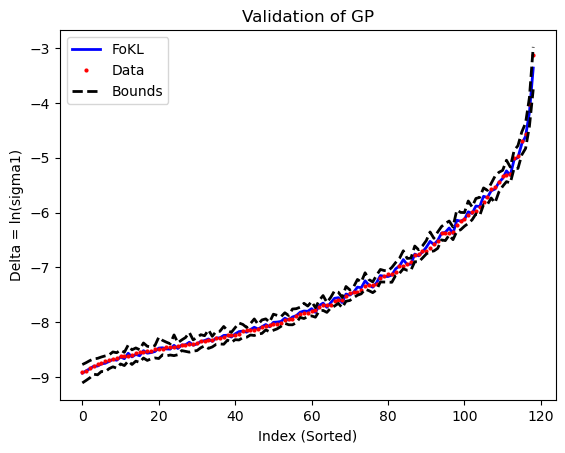

RMSE = 0.0007475039567492106


In [43]:
_, _, rmse = GP.coverage3(plot='sorted', ylabel='Delta = ln(sigma1)', title='Validation of GP')
print(f"RMSE = {rmse}")

Plotting $\mathbf{GP}$ at each experimental temperature:

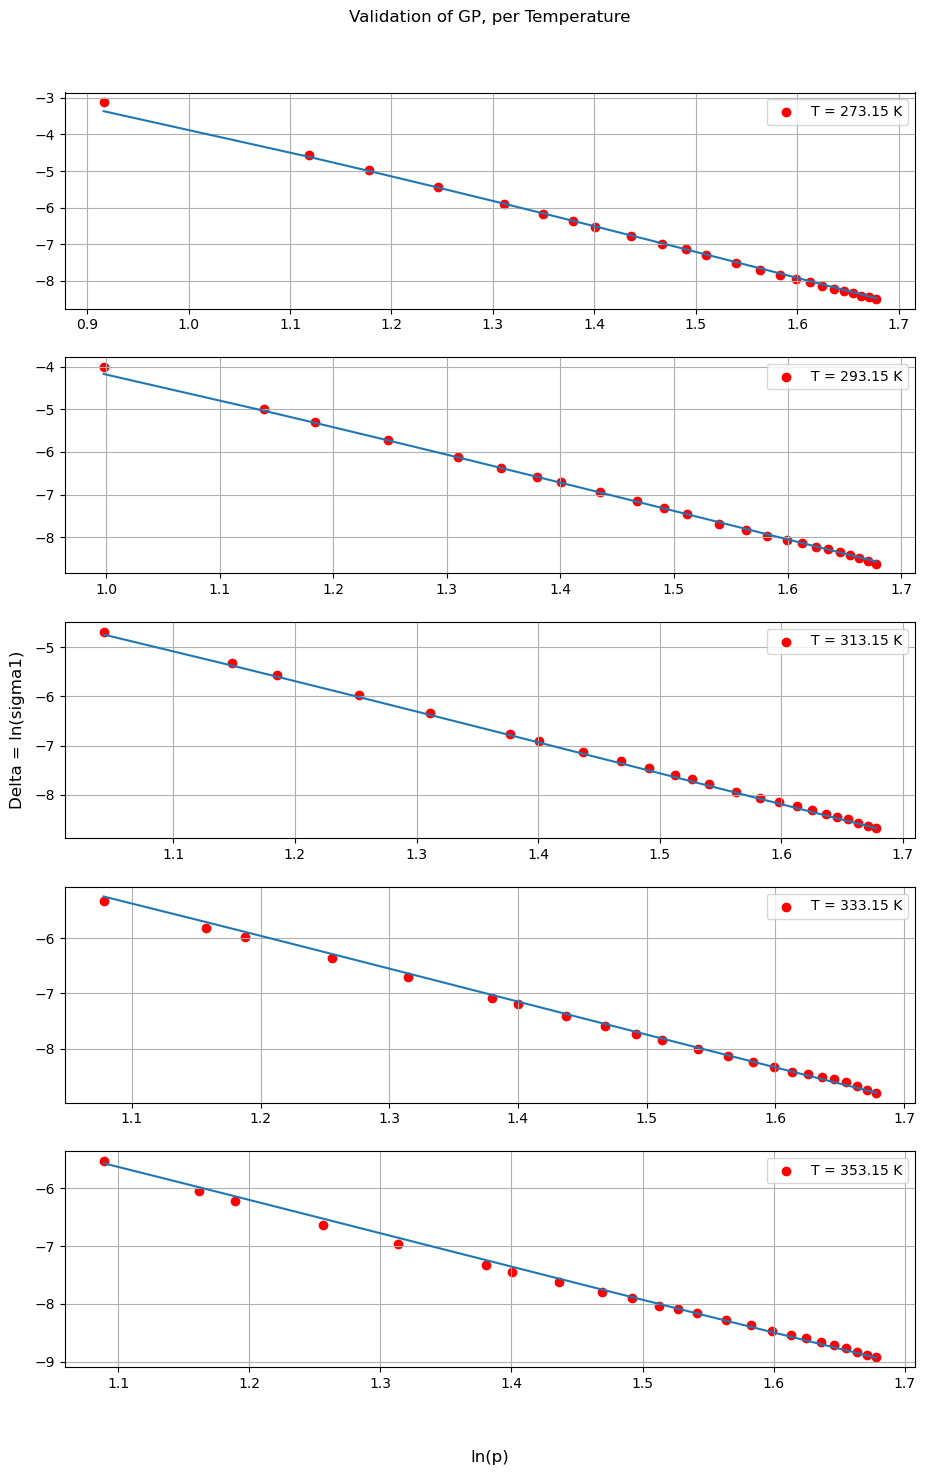

In [120]:
fig, axs = plt.subplots(n, figsize=(10, 15))
offset = 0.075
plt.subplots_adjust(left=offset, right=1-offset, bottom=offset, top=1-offset, hspace=3*offset)
fig.suptitle('Validation of GP, per Temperature')
fig.supxlabel('ln(p)')
fig.supylabel('Delta = ln(sigma1)')
for i in range(n):
    j, k = T_const[i], T_const[i + 1]
    inputs_i, Delta_i = GP.inputs[j:k, :], GP.data[j:k]
    ln_p_i = inputs_i[:, 1]

    axs[i].scatter(ln_p_i, Delta_i, color='r', label=f"T = {np.round(T[j], 2)} K")
    axs[i].plot(ln_p_i, GP.evaluate(inputs_i))

    axs[i].legend()
    axs[i].grid()

Calculate $q_{cal}$ predictions for comparison:

In [132]:
Delta_cal = GP.evaluate()
sigma1_cal = np.exp(Delta_cal)
qcal = eq6(sigma1_cal, qmax, mu)  # GP

qcal_Toth = eq8(qs, b, t, p_kPa)  # Toth

Plotting data, GP model, and Toth model for comparison:

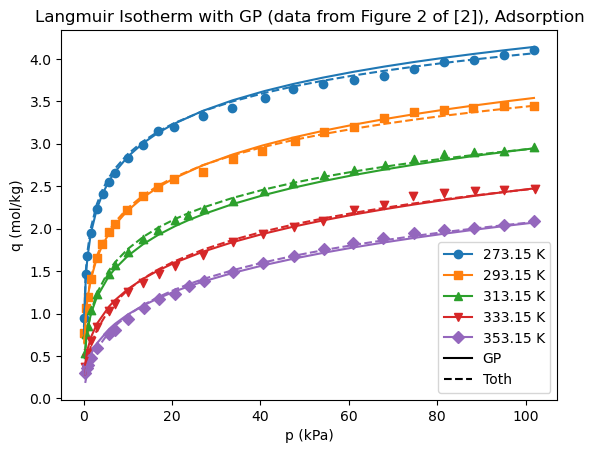

In [133]:
# Define styles and legend elements:

colors = mcolors.TABLEAU_COLORS  # dictionary of all colors
colors = list(colors.values())[:n]  # first 'n' colors, one per experiment

markers = ['o', 's', '^', 'v', 'D']
labels = list(f"{np.round(T[T_const[i]], 2)} K" for i in range(n))  # temperatures for legend

legend_elements = list(Line2D([0], [0], marker=markers[c], color=colors[c], label=labels[c]) for c in range(n)) + [Line2D([0], [0], ls='-', color='k', label='GP'), Line2D([0], [0], ls='--', color='k', label='Toth')]

# Plot:

fig, ax = plt.subplots()
for i in range(n):
    j = T_const[i]
    k = T_const[i + 1]

    plt.scatter(p_kPa[j:k], q[j:k], color=colors[i], marker=markers[i])  # experimental measurements
    plt.plot(p_kPa[j:k], qcal[j:k], '-', color=colors[i])  # GP model
    plt.plot(p_kPa[j:k], qcal_Toth[j:k], '--', color=colors[i])  # Toth model

ax.set_xlabel('p (kPa)')
ax.set_ylabel('q (mol/kg)')
ax.set_title('Langmuir Isotherm with GP (data from Figure 2 of [2]), Adsorption')
ax.legend(handles=legend_elements, loc='lower right')

Training $\mathbf{GP}_{q_{max}}$ to obtain $q_{max}$ at any $T$, and validating:

[1, -17.69427966356508]
[2, -27.995758655659905]
[3, -28.794436856119415]
[4, -248.67592442470777]
[5, -248.67592442470777]
[6, -248.67592442470777]
[7, -248.67592442470777]


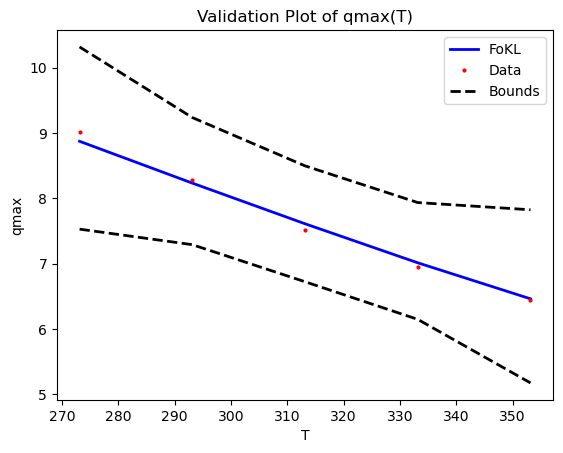

RMSE = 0.00047073118358405


In [176]:
# Training:
GP_qmax = FoKLRoutines.FoKL(kernel=1, UserWarnings=False, atau=1e-6)
_ = GP_qmax.fit(T[T_const[:-1]], qmax[T_const[:-1]], clean=True, minmax=[[T_min, T_max]])

# Validation:
_, _, rmse = GP_qmax.coverage3(plot=True, xaxis=0, xlabel='T', ylabel='qmax', title='Validation Plot of qmax(T)')
print(f"RMSE = {rmse}")

Reproducing $q/p$ plot but with $\theta_1$ instead of $q$, and using $\mathbf{GP}_{q_{max}}$ for calculation of the GP's $\theta_1$ value which greatly reduces accuracy but provides visual of what Pyomo will be working with:

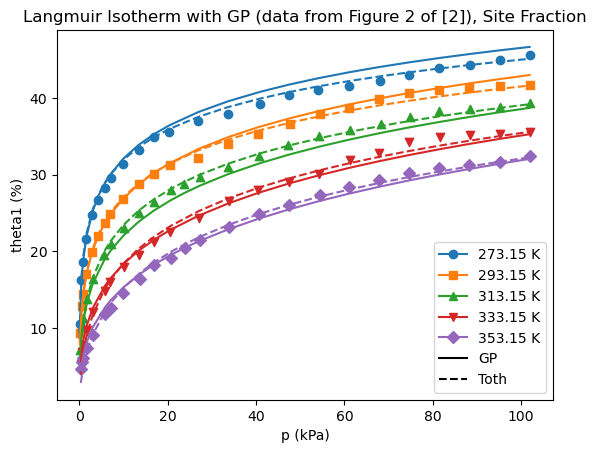

In [181]:
theta1_cal = np.zeros([sum(nd), 4])  # [measured, single GP, both GP's, Toth]

fig, ax = plt.subplots()
for i in range(n):
    j = T_const[i]
    k = T_const[i + 1]

    qcal
    
    
    theta1_cal[j:k, 0] = q[j:k] / qmax[j:k] * 100  # measured
    theta1_cal[j:k, 1] = qcal[j:k] / qmax[j:k] * 100  # single GP (for later percent error comparison)
    theta1_cal[j:k, 2] = qcal[j:k] / GP_qmax.evaluate(T[j:k], clean=True) * 100  # both GP's
    theta1_cal[j:k, 3] = qcal_Toth[j:k] / qmax[j:k] * 100  # Toth
    
    plt.scatter(p_kPa[j:k], theta1_cal[j:k, 0], color=colors[i], marker=markers[i])  # experimental measurements
    plt.plot(p_kPa[j:k], theta1_cal[j:k, 2], '-', color=colors[i])  # GP model (with qmax for GP_qmax, as Pyomo will use)
    plt.plot(p_kPa[j:k], theta1_cal[j:k, 3], '--', color=colors[i])  # Toth model

ax.set_xlabel('p (kPa)')
ax.set_ylabel('theta1 (%)')
ax.set_title('Langmuir Isotherm with GP (data from Figure 2 of [2]), Site Fraction')
ax.legend(handles=legend_elements, loc='lower right')

Comparing prediction from GP's to Toth:

In [190]:
# Calculate percent errors:

qcal_perc_error = np.zeros([sum(nd), 2])  # [GP, Toth]
theta1_cal_perc_error = np.zeros([sum(nd), 3])  # [GP, GP's, Toth]

def perc_error(measured, predicted):
    """Return percent error."""
    return (predicted - measured) / measured * 100

qcal_perc_error[:, 0] = perc_error(q, qcal)
qcal_perc_error[:, 1] = perc_error(q, qcal_Toth)  # should align with what is reported in [2]

for i in range(3):
    theta1_cal_perc_error[:, i] = perc_error(theta1_cal[:, 0], theta1_cal[:, i + 1])

# Compare/Print percent errors:

from tabulate import tabulate


table_q = [['GP (%)', 'Toth (%)']] + qcal_perc_error.tolist()
table_q_mean = [['GP (%)', 'Toth (%)'], np.mean(np.abs(qcal_perc_error), axis=0).tolist()]
table_q_std = [['GP (%)', 'Toth (%)'], np.std(qcal_perc_error, axis=0).tolist()]

table_theta1 = [['GP (%)', "GP's (%)", 'Toth (%)']] + theta1_cal_perc_error.tolist()
table_theta1_mean = [['GP (%)', "GP's (%)", 'Toth (%)'], np.mean(np.abs(theta1_cal_perc_error), axis=0).tolist()]
table_theta1_std = [['GP (%)', "GP's (%)", 'Toth (%)'], np.std(theta1_cal_perc_error, axis=0).tolist()]

print("q:")
print("Percent Error:")
print(tabulate(table_q, headers='firstrow', tablefmt='fancy_grid'))
print("Mean of Absolute:")
print(tabulate(table_q_mean, headers='firstrow', tablefmt='fancy_grid'))
print("Standard Deviation:")
print(tabulate(table_q_std, headers='firstrow', tablefmt='fancy_grid'))

print("theta1:")
print("Percent Error:")
print(tabulate(table_theta1, headers='firstrow', tablefmt='fancy_grid'))
print("Mean of Absolute:")
print(tabulate(table_theta1_mean, headers='firstrow', tablefmt='fancy_grid'))
print("Standard Deviation:")
print(tabulate(table_theta1_std, headers='firstrow', tablefmt='fancy_grid'))

q:
Percent Error:
╒═════════════╤═════════════╕
│      GP (%) │    Toth (%) │
╞═════════════╪═════════════╡
│ -19.6086    │ -11.5793    │
├─────────────┼─────────────┤
│  -3.84359   │   1.22221   │
├─────────────┼─────────────┤
│  -1.91624   │   2.29285   │
├─────────────┼─────────────┤
│  -0.606463  │   2.69208   │
├─────────────┼─────────────┤
│   0.129035  │   2.63204   │
├─────────────┼─────────────┤
│   0.338527  │   2.385     │
├─────────────┼─────────────┤
│   0.429942  │   2.14119   │
├─────────────┼─────────────┤
│   0.2892    │   1.75435   │
├─────────────┼─────────────┤
│   0.610422  │   1.67945   │
├─────────────┼─────────────┤
│   0.536666  │   1.25759   │
├─────────────┼─────────────┤
│  -0.69934   │  -0.248749  │
├─────────────┼─────────────┤
│   1.02143   │   1.25162   │
├─────────────┼─────────────┤
│   1.71311   │   1.60499   │
├─────────────┼─────────────┤
│   2.68549   │   2.29669   │
├─────────────┼─────────────┤
│   2.3024    │   1.66786   │
├─────────────┼───────

Converting $\mathbf{GP}_{q_{max}}$ to Pyomo for any optimization problem requiring $q(T, p)$:

In [191]:
m = fokl_to_pyomo([GP, GP_qmax], [['inv_T', 'ln_p'], ['T']], ['Delta', 'qmax'])

Developing Pyomo model:

In [192]:
# Create variables:
m.p = pyo.Var(within=pyo.NonNegativeReals)
m.sigma1 = pyo.Var(within=pyo.NonNegativeReals)
m.mu = pyo.Var(within=pyo.NonNegativeReals)
m.q = pyo.Var(within=pyo.NonNegativeReals)
m.theta1 = pyo.Var(within=pyo.NonNegativeReals, bounds=[0, 1])

# Define expressions:

m.constr_vars = pyo.ConstraintList()
m.constr_vars.add(expr=m.inv_T == 1/m.T)
m.constr_vars.add(expr=m.ln_p == log(m.p))

m.constr_eqs = pyo.ConstraintList()
m.constr_eqs.add(expr=m.mu == m.p/sqrt(2*np.pi*M*R*m.T))
m.constr_eqs.add(expr=m.sigma1 == exp(m.Delta))
m.constr_eqs.add(expr=m.q == m.sigma1*m.qmax*m.mu/(1 + m.sigma1*m.mu))
m.constr_eqs.add(expr=m.theta1 == m.q*m.qmax)

m.constr_eqs.pprint()

constr_eqs : Size=4, Index={1, 2, 3, 4}, Active=True
    Key : Lower : Body                               : Upper : Active
      1 :   0.0 :  mu - p/sqrt(2.2991139042557864*T) :   0.0 :   True
      2 :   0.0 :                sigma1 - exp(Delta) :   0.0 :   True
      3 :   0.0 : q - sigma1*qmax*mu/(1 + sigma1*mu) :   0.0 :   True
      4 :   0.0 :                    theta1 - q*qmax :   0.0 :   True


# NLP

Problem:
- Find optimal $(T, p)$ to maximize $\theta_1$ while minimizing USD cost.

Parameters:
- $T_{\text{USD}} = \$3.50\ /\text{K}$
- $p_{\text{USD}} = \$2.75 \cdot \exp(p)\ /\text{kPa}$

Solution:
- It is expected that $T$ is at minimum of bounds, since $\theta_1 \propto T^{-1}$.
- It is expected that $p \approx (10,\ 30)\ \text{kPa}$, since $\theta_1 \propto \frac{ap}{1+ap}$ which loosely has shape of log plot.

### Analytic Solution

#### WRONG:

$\text{USD} = T_{\text{USD}} + p_{\text{USD}}$

$\theta_1 / \text{USD} = \frac{ap}{(1+ap)(T_{\text{USD}} + p_{\text{USD}})} = \frac{a p}{(1+a p)(c_T + c_p \exp(p))}
= \frac{a p}{c_T + c_p \exp(p) + a c_T p + a c_p p \exp(p)}
= a \frac{p}{g(p)}$

To maximize,

$\frac{d}{dp}(\theta_1 / \text{USD})
= a \frac{g(p)-p \frac{d}{dp}(g(p))}{(g(p))^2}
= -a \left(\frac{(ac_pp^2+c_pp-c_p)\exp(p)-c_T}{(ap+1)^2(c_p\exp(p)+c_T)^2}\right)$

Then,

$(ac_pp^2+c_pp-c_p)\exp(p)-c_T = 0$

With $a$ calculated, $p$ may be solved for. To calculate $a$,

$a = \frac{\sigma_1}{\sqrt{2\pi MRT}}$

Then,

$(\frac{\sigma_1}{\sqrt{2\pi MRT_{min}}}c_pp^2+c_pp-c_p)\exp(p)-c_T = 0$

#### REDO WITH:

Parameters:
- $T_{\text{USD}} = \$3.50 \cdot T$
- $p_{\text{USD}} = \$2.75 \cdot \exp(p)$

...

Define costs and set up Pyomo objective:

In [193]:
m.cost = pyo.Var(within=pyo.NonNegativeReals)
m.constr_cost = pyo.ConstraintList()
m.constr_cost.add(expr=m.cost == 3.50*m.T + m.p*2.75)

m.obj = pyo.Objective(expr=m.theta1 / m.cost, sense=pyo.maximize)

Solve NLP:

In [194]:
local = True

# -----------

if local is True:  # for debugging
    solver = pyo.SolverFactory('ipopt')
    solver.solve(m, tee=True)
    
else:  # actual example
    solver = pyo.SolverFactory('multistart')
    solver.solve(m, solver='ipopt', suppress_unbounded_warning=True)

Ipopt 3.14.16: 
Exception of type: DYNAMIC_LIBRARY_FAILURE in file "Common/IpLibraryLoader.cpp" at line 86:
 Exception message: libhsl.so: cannot open shared object file: No such file or directory

EXIT: Library loading failure.
model.name="unknown";
    - termination condition: other
    - message from solver: <undefined>


Retrieve solution:

In [195]:
sol = {'T': m.T(), 'p': m.p(), 'theta1': m.theta1(), 'cost': m.cost()}

print(f"     T = {sol['T']} K")
print(f"     p = {sol['p']} kPa")
print(f"theta1 = {np.round(sol['theta1'] * 100, 2)} %")
print(f"  cost = ${np.round(sol['cost'], 2)}")

print(f"{np.round(sol['theta1'] * 100 / sol['cost'], 2)} %/USD")

     T = 300.0 K
     p = None kPa


TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

Note it is expected that $T$ is at minimum of bounds, since $theta_1 \propto T^{-1}$; however, since $q \propto 

## References

<c id=1> [1] <c/> [THE ADSORPTION OF GASES ON PLANE SURFACES OF GLASS, MICA AND PLATINUM. <br>
&emsp;&nbsp; Irving Langmuir <br>
&emsp;&nbsp; Journal of the American Chemical Society 1918 40 (9), 1361-1403 <br>
&emsp;&nbsp; DOI: 10.1021/ja02242a004](https://pubs.acs.org/doi/epdf/10.1021/ja02242a004) <br>

<c id=2> [2] <c/> [Adsorption Equilibria of CO2 on Zeolite 13X and Zeolite X/Activated Carbon Composite <br>
&emsp;&nbsp; Jong-Seok Lee, Jong-Hwa Kim, Jin-Tae Kim, Jeong-Kwon Suh, Jung-Min Lee, and Chang-Ha Lee <br>
&emsp;&nbsp; Journal of Chemical & Engineering Data 2002 47 (5), 1237-1242 <br>
&emsp;&nbsp; DOI: 10.1021/je020050e](https://pubs.acs.org/doi/10.1021/je020050e) <br>